## Sentiment Analysis of Real-time Flipkart Product Reviews

### Objective
1. The objective of this project is to classify customer reviews as positive or negative and understand the pain points of customers who write negative reviews. 
`Understanding Pain Points`: Analyzing negative reviews to __identify common themes or issues raised by customers__. This analysis can provide valuable insights into areas where the business may need improvement or where customer expectations are not being met.
1. By analyzing the sentiment of reviews, we aim to gain insights into product features that contribute to customer satisfaction or dissatisfaction.


Overall, the project aims to help businesses gain a better understanding of customer sentiment, identify areas for improvement, and ultimately enhance customer satisfaction and loyalty.

In [119]:
import re
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [120]:
shuttle = r"reviews_badminton\data.csv"
tawa = r"reviews_tawa\data.csv"
tea = r"reviews_tea\data.csv"

In [121]:
shuttle_df = pd.read_csv(shuttle)
tawa_df = pd.read_csv(tawa)
tea_df = pd.read_csv(tea)

In [122]:
print(shuttle_df.shape)
shuttle_df.head(3)

(8518, 8)


,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1


In [123]:
print(tawa_df.shape)
tawa_df.head(3)

(2531, 8)


,Reviewer_Name,Reviewer_Rating,Review_Title,Review_Text,Place_of_Review,Date_of_Review,Up_Votes,Down_Votes
0,Sumit Kumar,5.0,Wonderful,I think In this price category it's best dosa ...,"Certified Buyer, Lakhisarai",Sumit Kumar,211,39
1,BHARAT GALAGALI,5.0,Mind-blowing purchase,perfect tawa for Dosa..READ MORE,"Certified Buyer, Hunsur",BHARAT GALAGALI,107,17
2,Paramjeet Singh,5.0,Awesome,Excellent tawa. Made Paneer Tikka on first day...,"Certified Buyer, Rampura Phul",Paramjeet Singh,59,8


In [124]:
print(tea_df.shape)
tea_df.head(3)

(9170, 8)


,reviewer_name,reviewer_rating,review_title,review_text,place_of_review,Date_of_review,up_votes,Down_votes
0,Subhro Banerjee,5,Worth every penny,Great product 🤗 with great deals 😍😍 Tata Tea G...,"Certified Buyer, Budge Budge",Subhro Banerjee,236,59
1,Shiv chandra Jha,5,Great product,Very nice and super qwality tea taste are grea...,"Certified Buyer, Saharsa",Shiv chandra Jha,225,79
2,Flipkart Customer,5,Highly recommended,Great test great quality great price point tim...,"Certified Buyer, Sri Ganganagar",Flipkart Customer,89,27


In [125]:
shuttle_df = shuttle_df.iloc[:-10,:]

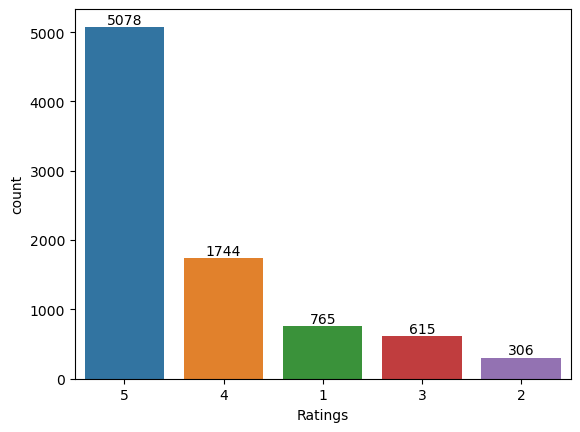

In [126]:
counts = shuttle_df.Ratings.value_counts()
sns.countplot(data=shuttle_df, 
			x='Ratings', 
			order=counts.index)

# Add counts to the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()

In [127]:
shuttle_df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [128]:
shuttle_df.isnull().sum()

Reviewer Name        0
Review Title         0
Place of Review     40
Up Votes             0
Down Votes           0
Month              455
Review text          0
Ratings              0
dtype: int64

## Data Preprocessing
1. Text Cleaning: Remove special characters, punctuation, and stopwords from the review text.
2. Text Normalization: Perform lemmatization or stemming to reduce words to their base forms.
3. Numerical Feature Extraction: Apply techniques like Bag-of-Words (BoW), Term Frequency-Inverse Document Frequency (TF-IDF), Word2Vec (W2V), and BERT models for feature extraction.


In [129]:
shuttle_df

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...,...,...,...,...,...,...
8503,darwin,Yones Mavis 350 Blue cap,NaN,2.0,0.0,Apr 2016,Wrost and duplicate productDon't buy this sell...,1
8504,naresh g,For Mavis350,NaN,2.0,1.0,Aug 2016,Received product intact and sealedREAD MORE,5
8505,MD. Jabbar,Very Good,NaN,1.0,0.0,Sep 2016,Delivered before time but price is high from m...,3
8506,Abani Behera,Don't waste your money,NaN,0.0,2.0,Sep 2016,up to the mark but same is available in market...,4


## Data Preprocessing

In [130]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [131]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    if text[-9:] == 'read more':
        text = text[:-9]
    return text

In [132]:
shuttle_df['clean_text'] = shuttle_df['Review text'].apply(clean_text)

In [133]:
shuttle_df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,clean_text
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,nice product good quality but price is now ris...
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,they didnt supplied yonex mavis outside cover...
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,worst product damaged shuttlecocks packed in n...
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3,quite o k but nowadays the quality of the co...
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,over pricedjust from retaileri didnt understa...


In [134]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.discard('not')

def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [135]:
shuttle_df['clean_stopwords'] = shuttle_df['clean_text'].apply(remove_stopwords)

In [136]:
shuttle_df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,clean_text,clean_stopwords
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,nice product good quality but price is now ris...,nice product good quality price rising bad sig...
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,they didnt supplied yonex mavis outside cover...,didnt supplied yonex mavis outside cover yonex...
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,worst product damaged shuttlecocks packed in n...,worst product damaged shuttlecocks packed new ...
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3,quite o k but nowadays the quality of the co...,quite k nowadays quality corks like not years ...
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,over pricedjust from retaileri didnt understa...,pricedjust retaileri didnt understand wat adva...


In [137]:
# Text Normalization
def normalize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    normalized_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return normalized_text

In [138]:
shuttle_df['lamma_text'] = shuttle_df['clean_stopwords'].apply(normalize_text)

In [ ]:
shuttle_df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,clean_text,clean_stopwords,lamma_text
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,nice product good quality but price is now ris...,nice product good quality price rising bad sig...,nice product good quality price rising bad sig...
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,they didnt supplied yonex mavis outside cover...,didnt supplied yonex mavis outside cover yonex...,didnt supplied yonex mavis outside cover yonex...
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,worst product damaged shuttlecocks packed in n...,worst product damaged shuttlecocks packed new ...,worst product damaged shuttlecock packed new b...
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3,quite o k but nowadays the quality of the co...,quite k nowadays quality corks like not years ...,quite k nowadays quality cork like not year ba...
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,over pricedjust from retaileri didnt understa...,pricedjust retaileri didnt understand wat adva...,pricedjust retaileri didnt understand wat adva...


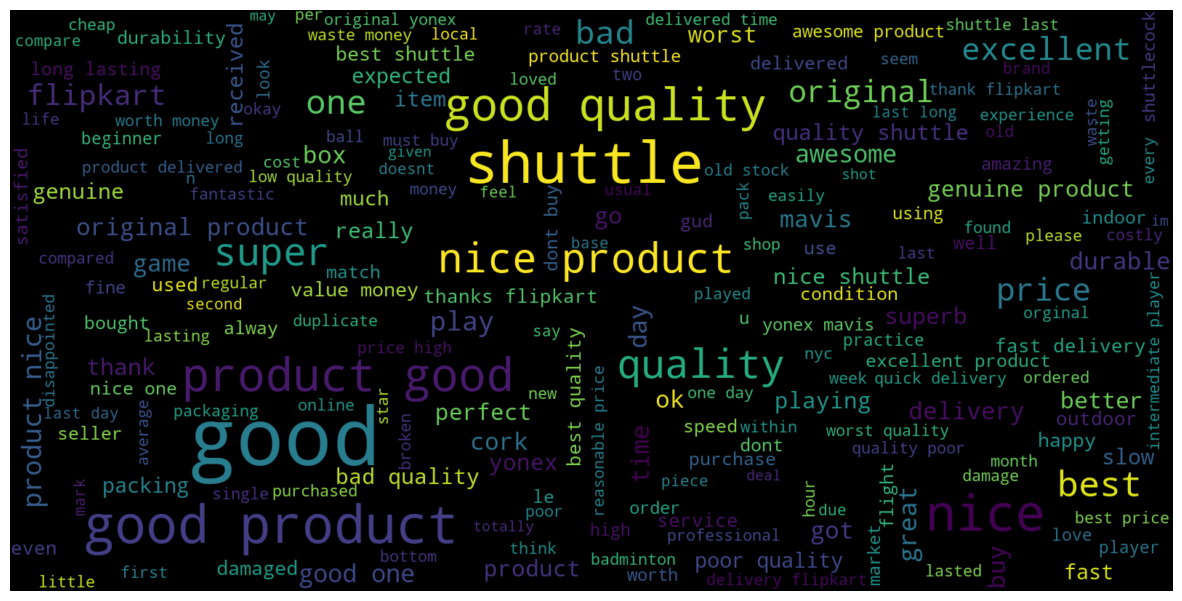

In [ ]:
consolidated = ' '.join( 
	word for word in shuttle_df['lamma_text'].astype(str)) 
wordCloud = WordCloud(width=1600, height=800, 
					random_state=21, max_font_size=110) 
plt.figure(figsize=(15, 10)) 
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear') 
plt.axis('off') 
plt.show() 

## Fine the sentiment of the text using __SentimentIntensityAnalyzer__

In [ ]:
shuttle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8508 entries, 0 to 8507
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8508 non-null   object 
 7   Ratings          8508 non-null   int64  
 8   clean_text       8508 non-null   object 
 9   clean_stopwords  8508 non-null   object 
 10  lamma_text       8508 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 731.3+ KB


In [ ]:
# Sentiment Analysis
def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score >= 0:
        return 1
    else:
        return 0

In [ ]:
shuttle_df['sentiment'] = shuttle_df['lamma_text'].apply(analyze_sentiment)

In [ ]:
shuttle_df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,clean_text,clean_stopwords,lamma_text,sentiment
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,nice product good quality but price is now ris...,nice product good quality price rising bad sig...,nice product good quality price rising bad sig...,1
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,they didnt supplied yonex mavis outside cover...,didnt supplied yonex mavis outside cover yonex...,didnt supplied yonex mavis outside cover yonex...,0
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,worst product damaged shuttlecocks packed in n...,worst product damaged shuttlecocks packed new ...,worst product damaged shuttlecock packed new b...,0
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3,quite o k but nowadays the quality of the co...,quite k nowadays quality corks like not years ...,quite k nowadays quality cork like not year ba...,1
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,over pricedjust from retaileri didnt understa...,pricedjust retaileri didnt understand wat adva...,pricedjust retaileri didnt understand wat adva...,0


In [ ]:
# Update 'sentiment' column based on conditions
shuttle_df.loc[(shuttle_df['sentiment'] == 1) & (shuttle_df['Ratings'] > 3), 'sentiment'] = 1
shuttle_df.loc[~((shuttle_df['sentiment'] == 1) & (shuttle_df['Ratings'] > 3)), 'sentiment'] = 0

In [ ]:
shuttle_df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,clean_text,clean_stopwords,lamma_text,sentiment
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,nice product good quality but price is now ris...,nice product good quality price rising bad sig...,nice product good quality price rising bad sig...,1
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,they didnt supplied yonex mavis outside cover...,didnt supplied yonex mavis outside cover yonex...,didnt supplied yonex mavis outside cover yonex...,0
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,worst product damaged shuttlecocks packed in n...,worst product damaged shuttlecocks packed new ...,worst product damaged shuttlecock packed new b...,0
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3,quite o k but nowadays the quality of the co...,quite k nowadays quality corks like not years ...,quite k nowadays quality cork like not year ba...,0
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,over pricedjust from retaileri didnt understa...,pricedjust retaileri didnt understand wat adva...,pricedjust retaileri didnt understand wat adva...,0


In [ ]:
shuttle_df['sentiment'].value_counts(normalize=True)

sentiment
1    0.787847
0    0.212153
Name: proportion, dtype: float64

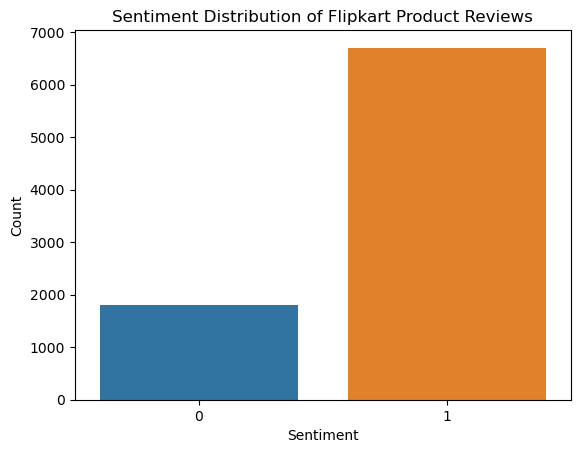

In [ ]:
# Visualization
sns.countplot(data=shuttle_df, x='sentiment')
plt.title('Sentiment Distribution of Flipkart Product Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### Word cloud for Good Review

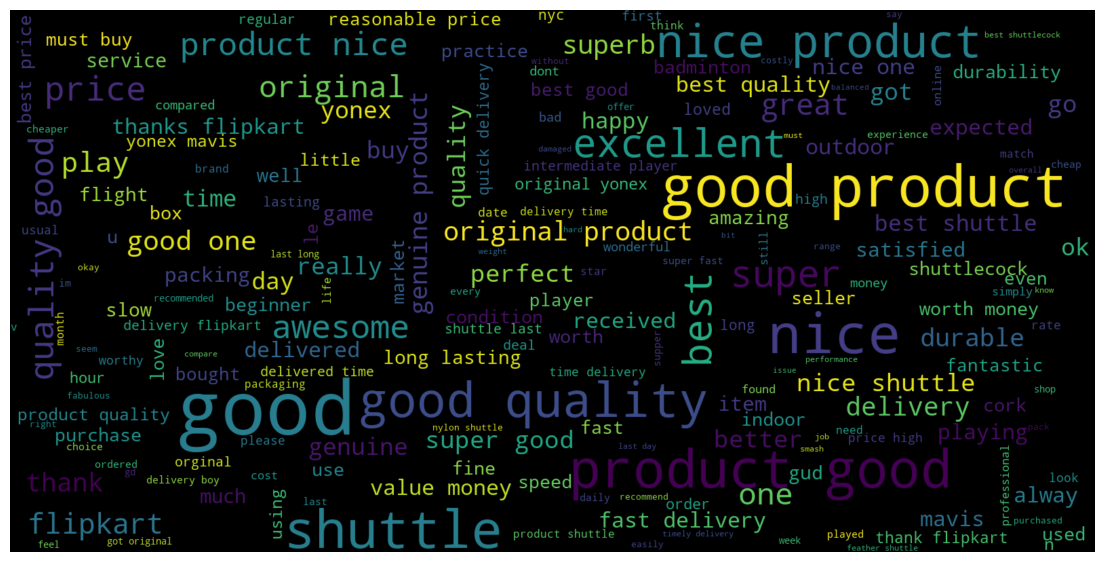

In [ ]:
consolidated = ' '.join(
	word for word in shuttle_df['lamma_text'][shuttle_df['sentiment'] == 1].astype(str))
wordCloud = WordCloud(width=1600, height=800,
					random_state=21, max_font_size=110)
plt.figure(figsize=(14, 9))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

### Word Cloud for Bed Review

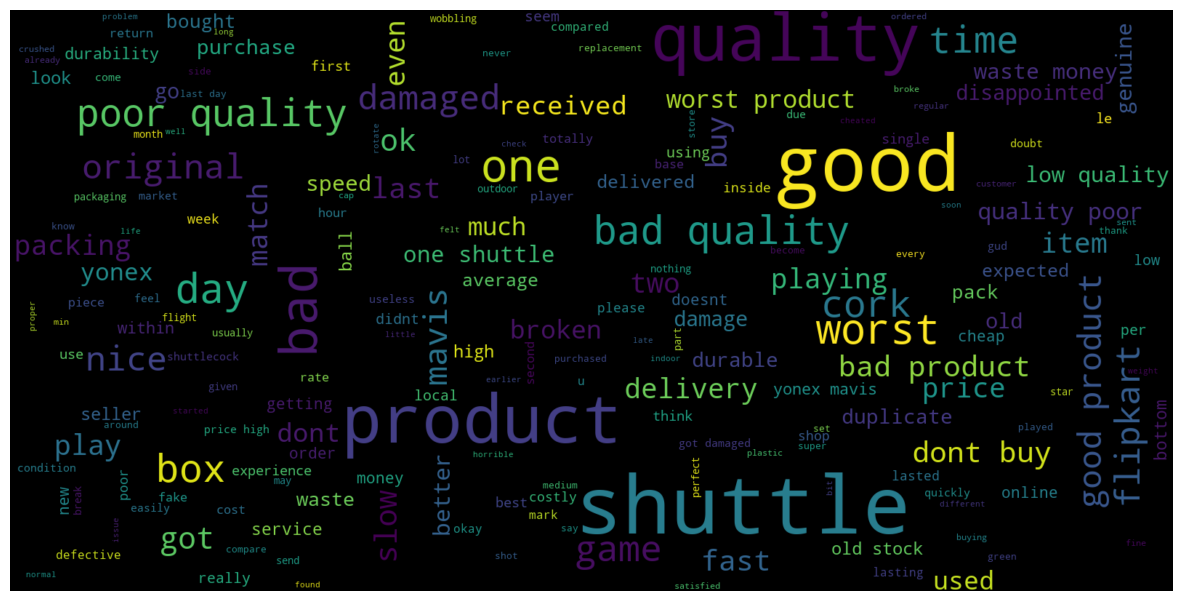

In [ ]:
consolidated = ' '.join(
	word for word in shuttle_df['lamma_text'][shuttle_df['sentiment'] == 0].astype(str))
wordCloud = WordCloud(width=1600, height=800,
					random_state=21, max_font_size=110)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
shuttle_df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,clean_text,clean_stopwords,lamma_text,sentiment
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,nice product good quality but price is now ris...,nice product good quality price rising bad sig...,nice product good quality price rising bad sig...,1
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,they didnt supplied yonex mavis outside cover...,didnt supplied yonex mavis outside cover yonex...,didnt supplied yonex mavis outside cover yonex...,0
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,worst product damaged shuttlecocks packed in n...,worst product damaged shuttlecocks packed new ...,worst product damaged shuttlecock packed new b...,0
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3,quite o k but nowadays the quality of the co...,quite k nowadays quality corks like not years ...,quite k nowadays quality cork like not year ba...,0
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,over pricedjust from retaileri didnt understa...,pricedjust retaileri didnt understand wat adva...,pricedjust retaileri didnt understand wat adva...,0


In [ ]:
X = shuttle_df['lamma_text']
y = shuttle_df['sentiment']
print(X.shape, y.shape)

(8508,) (8508,)


### Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=True)

In [ ]:
X_train, y_train

(6215    good acceptable product dilivery also good
 8305                                  nice project
 3419                                  good shuttle
 5721                                          good
 134                                    bad quality
                            ...                    
 2895                                  quality good
 7813                   not bad really good quality
 905                                           good
 5192                                           bad
 235                                    bad quality
 Name: lamma_text, Length: 6806, dtype: object,
 6215    1
 8305    1
 3419    1
 5721    1
 134     0
        ..
 2895    1
 7813    1
 905     1
 5192    0
 235     0
 Name: sentiment, Length: 6806, dtype: int64)

In [ ]:
X_test, y_test

(3477                                     perfect original
 5465                             best intermediate player
 4600         price goodquality goodand also fast delivery
 6363                                                happy
 3178                                         good product
                               ...                        
 6870    shuttle different compared buy showroom dont k...
 4484                                        not good hard
 3774                            yonox yonox great quality
 6279                                            bad corck
 4485                                 super really amazing
 Name: lamma_text, Length: 1702, dtype: object,
 3477    1
 5465    1
 4600    1
 6363    1
 3178    1
        ..
 6870    0
 4484    0
 3774    1
 6279    0
 4485    1
 Name: sentiment, Length: 1702, dtype: int64)

### Preprocess the train data

In [ ]:
cv = TfidfVectorizer()

In [ ]:
X_train_vector = cv.fit_transform(X_train).toarray()

In [ ]:
print(X_train_vector.shape)
X_train_vector, y_train

(6806, 2542)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 6215    1
 8305    1
 3419    1
 5721    1
 134     0
        ..
 2895    1
 7813    1
 905     1
 5192    0
 235     0
 Name: sentiment, Length: 6806, dtype: int64)

### Preprocess the test data

In [ ]:
X_test_vector = cv.transform(X_test).toarray()

In [ ]:
X_test_vector, y_test

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 3477    1
 5465    1
 4600    1
 6363    1
 3178    1
        ..
 6870    0
 4484    0
 3774    1
 6279    0
 4485    1
 Name: sentiment, Length: 1702, dtype: int64)

### Apply Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train_vector, y_train)

#testing the model
train_pred = model.predict(X_train_vector)
test_pred = model.predict(X_test_vector)

print("Train Score :", accuracy_score(y_train, train_pred))
print("Test Score  :", accuracy_score(y_test, test_pred))

Train Score : 0.967234792829856
Test Score  : 0.8965922444183314


### Apply SVM

In [ ]:
from sklearn.svm import SVC

model = SVC(random_state=0)
model.fit(X_train_vector, y_train)

#testing the model
train_pred = model.predict(X_train_vector)
test_pred = model.predict(X_test_vector)

print("Train Score :", accuracy_score(y_train, train_pred))
print("Test Score  :", accuracy_score(y_test, test_pred))

Train Score : 0.9540111666176903
Test Score  : 0.9124559341950647


### Apply Random Forest  

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)
model.fit(X_train_vector, y_train)

#testing the model
train_pred = model.predict(X_train_vector)
test_pred = model.predict(X_test_vector)

print("Train Score :", accuracy_score(y_train, train_pred))
print("Test Score  :", accuracy_score(y_test, test_pred))

Train Score : 0.967234792829856
Test Score  : 0.9130434782608695


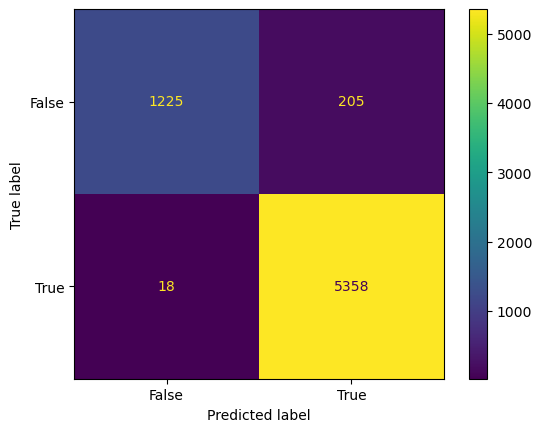

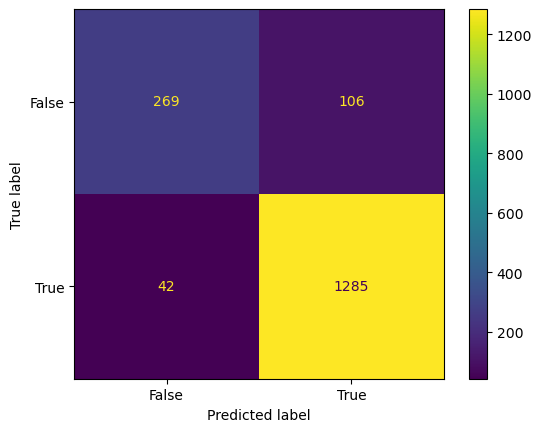

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, train_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

cm = confusion_matrix(y_test, test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

### Save the model

In [ ]:
import joblib

joblib.dump(model, 'rf_model.pkl')

['rf_model.pkl']

### Save the vectorizer

In [ ]:
# Save the fitted TfidfVectorizer object
joblib.dump(cv, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [ ]:
rf_model = joblib.load('rf_model.pkl')

pred = rf_model.predict([X_test_vector[0]])
print(f"Given Text = {X_test.iloc[0]}\n Prediction = {pred}")

Given Text = perfect original
 Prediction = [1]


In [ ]:
X_test

3477                                     perfect original
5465                             best intermediate player
4600         price goodquality goodand also fast delivery
6363                                                happy
3178                                         good product
                              ...                        
6870    shuttle different compared buy showroom dont k...
4484                                        not good hard
3774                            yonox yonox great quality
6279                                            bad corck
4485                                 super really amazing
Name: lamma_text, Length: 1702, dtype: object

In [ ]:

review = cv.transform(["great product"]).toarray()
rf_model.predict(review)

array([1], dtype=int64)

### Predict new value

In [1]:
import re
import nltk
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stop_words.discard('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    normalized_text = ' '.join([lemmatizer.lemmatize(token) for token in filtered_tokens])
    
    return normalized_text

In [3]:
review = "Yonox is954 yonox Great quality)*^"
review = preprocess_text(review)

In [4]:
cv = joblib.load('tfidf_vectorizer.pkl')
review = cv.transform([review]).toarray()

In [5]:
rf_model = joblib.load('rf_model.pkl')
predict = rf_model.predict(review)[0]
predict

1